In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Open MERRA-2 data

In [2]:
datapath = "../data.MERRA-2.tavg1_2d_slv_Nx.200107/"

filename_TS = "data-TS_hadv.nc"
filename_QV2M = "data-QV2M_hadv.nc"

file_TS = datapath+"/"+filename_TS
file_QV2M = datapath+"/"+filename_QV2M

#--- use xarray to open the files
ds_TS = yhc.wrap360 (xr.open_dataset(file_TS))
ds_QV2M = yhc.wrap360 (xr.open_dataset(file_QV2M))

file_merra2 = datapath+"/"+"MERRA2_300.tavg1_2d_slv_Nx.*"
ds_merra2 = yhc.wrap360 (xr.open_mfdataset(file_merra2))

ds_QV2M

<xarray.Dataset>
Dimensions:          (lon: 576, time: 720, lat: 361)
Coordinates:
  * lon              (lon) float64 0.625 1.25 1.875 2.5 ... 358.8 359.4 360.0
  * time             (time) datetime64[ns] 2001-07-01T00:30:00 ... 2001-07-30...
  * lat              (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
Data variables:
    QV2M_adv_sphere  (time, lat, lon) float32 ...
    QV2M_adv_cfd     (time, lat, lon) float64 ...

## Open CGILS data

In [3]:
datapath_cgils = "/work/Yi-hsuan.Chen/research/data.CGILS_forcing"

filename_ctl_s11 = datapath_cgils+"/"+"ctl_s11.nc"
ctl_s11 = xr.open_dataset(filename_ctl_s11)

filename_ctl_s12 = datapath_cgils+"/"+"ctl_s12.nc"
ctl_s12 = xr.open_dataset(filename_ctl_s12)

## get region-avg values

In [4]:
region = "DYCOMS"

TS_adv_sphere_ijavg = yhc.get_area_avg(ds_TS.TS_adv_sphere, region)
TS_adv_cfd_ijavg = yhc.get_area_avg(ds_TS.TS_adv_cfd, region)

QV2M_adv_sphere_ijavg = yhc.get_area_avg(ds_QV2M.QV2M_adv_sphere, region)
QV2M_adv_cfd_ijavg = yhc.get_area_avg(ds_QV2M.QV2M_adv_cfd, region)

## Compute CGILS-type moisture advection

In [5]:
T2M_ijavg = yhc.get_area_avg(ds_merra2.T2M, region)
QV2M_ijavg = yhc.get_area_avg(ds_merra2.QV2M, region)
PS_ijavg = yhc.get_area_avg(ds_merra2.PS, region)

T2M_ijavg_C = T2M_ijavg.copy() - 273.15  # change unit from C to K
PS_ijavg_hPa = PS_ijavg.copy() / 100.    # change unit from Pa to hPa

RH_ijavg = yhc.rh(T2M_ijavg_C, PS_ijavg_hPa, QV2M_ijavg)
dqs_dT_ijavg = yhc.dqs_dT(T2M_ijavg_C, PS_ijavg_hPa)

QV_adv_CGILS_sphere_ijavg = TS_adv_sphere_ijavg * RH_ijavg * dqs_dT_ijavg

#print(QV_adv_CGILS_sphere_ijavg)
print(RH_ijavg)

#ds_merra2

<xarray.DataArray (time: 720)>
dask.array<truediv, shape=(720,), dtype=float64, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-07-01T00:30:00 ... 2001-07-30T23:30:00
Attributes:
    standard_name:   2-meter_specific_humidity
    long_name:       2-meter_specific_humidity
    units:           kg kg-1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0


## plot

In [6]:
#==============================
def ax_def_xy (ax, var):

    #--- set grids
    ax.grid(True)
    ax.minorticks_on()
    
    #--- legend
    #ax.legend(legend)
    
    #--- set x or y labels
    ax.set_xlabel("Date in July 2001")

    #--- set title
    ax.set_title(var.attrs['long_name'], loc='left')
    ax.set_title(var.attrs['units'], loc='right')
    ax.set_ylabel(var.attrs['long_name']+" ("+var.attrs['units']+")")
    
    #--- set x range
    ax.set_xlim([0,len(var)])
    
    #--- set x tickmark
    day = np.arange(1,31)
    gg = np.arange(0,720,24)
    ax.set_xticks(gg)        # tickmark values
    ax.set_xticklabels(day)  # tickmark labels
    
#============================== 

day = np.arange(1,31)
gg = np.arange(0,720,24)

#date00 = "July "+str(day)
#print(date00)

#print(len(gg))
#print(len(day))


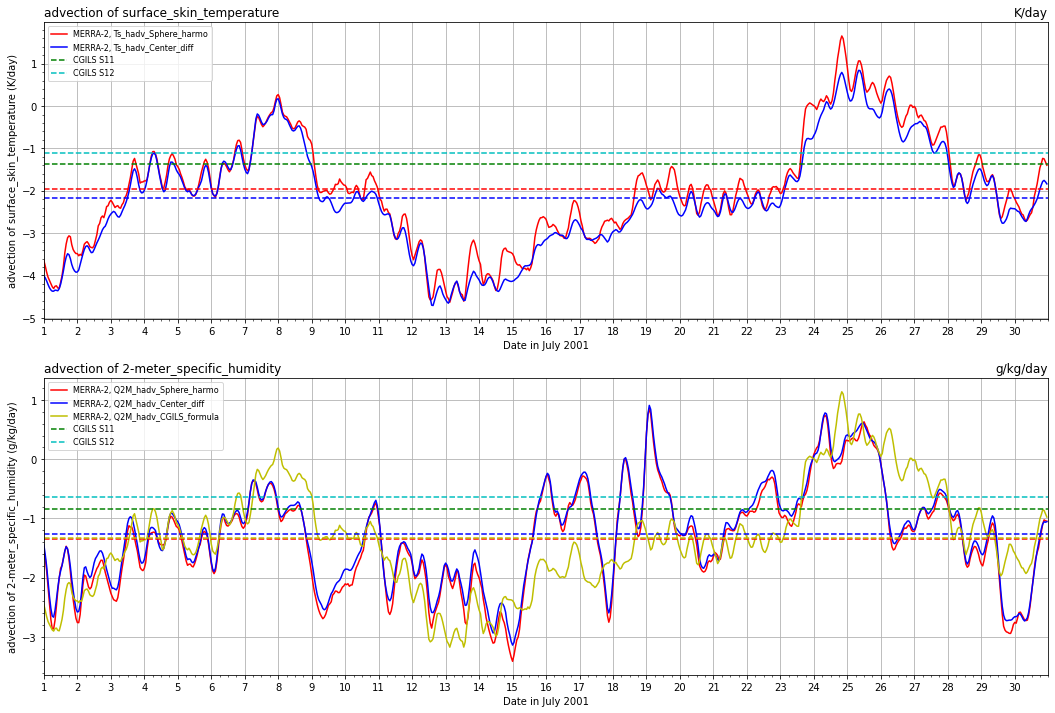

In [13]:
tt = np.arange(0,len(TS_adv_cfd_ijavg.time))

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18, 12))
#fig.tight_layout()

style1 = 'r-'
style1a = style1+"-"
style2 = 'b-'
style2a = style2+"-"
style3 = 'y-'
style3a = style3+"-"
style4 = 'g--'

tt2 = np.array([0.,720.])
ctl_s11_divT = np.array([ctl_s11.divT[0,-1,0,0], ctl_s11.divT[0,-1,0,0]])
ctl_s12_divT = np.array([ctl_s12.divT[0,-1,0,0], ctl_s12.divT[0,-1,0,0]])

TS_adv_sphere_ijtavg = TS_adv_sphere_ijavg.mean("time") * (-86400.)
TS_adv_cfd_ijtavg = TS_adv_cfd_ijavg.mean("time") * (-86400.)

TS_sphere_pp = np.array([TS_adv_sphere_ijtavg,TS_adv_sphere_ijtavg])
TS_cfd_pp = np.array([TS_adv_cfd_ijtavg,TS_adv_cfd_ijtavg])

#print(TS_adv_sphere_ijtavg)

#--- ax1

ax1.plot(tt, -TS_adv_sphere_ijavg*86400., style1, 
         tt, -TS_adv_cfd_ijavg*86400., style2, 
         tt2, ctl_s11_divT*86400., style4,
         tt2, ctl_s12_divT*86400., 'c--',
         tt2, TS_sphere_pp, style1a, 
         tt2, TS_cfd_pp, style2a, 
        )
ax1.legend(["MERRA-2, Ts_hadv_Sphere_harmo","MERRA-2, Ts_hadv_Center_diff", "CGILS S11", "CGILS S12"], fontsize = 8)
var1 = yhc.unit_convert(TS_adv_sphere_ijavg)
var1.attrs['units'] = 'K/day'
ax_def_xy(ax1, var1)

#--- ax2

ctl_s11_divq = np.array([ctl_s11.divq[0,-1,0,0], ctl_s11.divq[0,-1,0,0]])
ctl_s12_divq = np.array([ctl_s12.divq[0,-1,0,0], ctl_s12.divq[0,-1,0,0]])

QV2M_adv_sphere_ijtavg = QV2M_adv_sphere_ijavg.mean("time") * (-86400.*1000.)
QV2M_adv_cfd_ijtavg = QV2M_adv_cfd_ijavg.mean("time") * (-86400.*1000.)
QV_adv_CGILS_sphere_ijtavg = QV_adv_CGILS_sphere_ijavg.mean() * (-86400.*1000.)

QV2M_sphere_pp = np.array([QV2M_adv_sphere_ijtavg,QV2M_adv_sphere_ijtavg])
QV2M_cfd_pp = np.array([QV2M_adv_cfd_ijtavg,QV2M_adv_cfd_ijtavg])
QV2M_CGILS_pp = np.array([QV_adv_CGILS_sphere_ijtavg, QV_adv_CGILS_sphere_ijtavg])

ax2.plot(tt, -QV2M_adv_sphere_ijavg*1000.*86400., style1, 
         tt, -QV2M_adv_cfd_ijavg*1000.*86400., style2, 
         tt, -QV_adv_CGILS_sphere_ijavg*1000.*86400., style3,
         tt2, ctl_s11_divq*86400.*1000., style4,
         tt2, ctl_s12_divq*86400.*1000., 'c--',
         tt2, QV2M_sphere_pp, style1a, 
         tt2, QV2M_cfd_pp, style2a, 
         tt2, QV2M_CGILS_pp, style3a, 
        )
#ax2.legend(["Q2M_hadv_Sphere_harmo","Q2M_hadv_Center_diff","QS_hadv_CGILS_formula"])
ax2.legend(["MERRA-2, Q2M_hadv_Sphere_harmo","MERRA-2, Q2M_hadv_Center_diff", "MERRA-2, Q2M_hadv_CGILS_formula", "CGILS S11", "CGILS S12"], fontsize = 8)

var2 = QV2M_adv_sphere_ijavg
var2.attrs['units'] = 'g/kg/day'
ax_def_xy(ax2, var2)




## plot over map

In [ ]:
ds_merra2

lon = ds_merra2.lon
lat = ds_merra2.lat

T2M = ds_merra2.T2M[0,:,:]
U10M = ds_merra2.U10M[0,:,:]
V10M = ds_merra2.V10M[0,:,:]

var1 = yhc.unit_convert(ds_TS.TS_adv_sphere[0,:,:])
var1

ds_merra2

In [ ]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')
ax.set_extent([-115, -125, 25, 35])

# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(280.,300,1)
plt.contourf(lon, lat, T2M, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
#plt.contourf(lon, lat, ds_TS.TS_adv_sphere, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('MERRA-2 Air Temperature at 2m, January 2010', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('K',size=12,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)

plt.quiver(lon, lat, U10M, V10M, pivot='middle')

# plot T2M
#clevs_T2M = np.arange(280., 300., 5.)
#cs = ax.contour(lon, lat, T2M, clevs_T2M, colors='black', transform=ccrs.PlateCarree())
#plt.clabel(cs, fmt='%d')

In [ ]:
yhc.lib("unit_convert")

In [ ]:
help(yhc.unit_convert)